# Threaded Merge Sort

In deze notebook wordt de PoC implementatie van een threaded merge sort weergeven. Voor deze implementatie is gebruik gemaakt van de *threading* module van Python.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import threading
import logging
import math
import time

Aangezien er uiteindelijk gebruik gemaakt gaat worden van merge sort is ervoor gekozen om een functie ervan te maken. Deze functie krijgt een ongesorteerde lijst van getallen binnen en sorteert deze lijst met behulp van het merge sort algoritme tot een gesorteerde lijst alvorens deze terug te geven.

In [2]:
def merge_sort(arr):
    """
    Uses the merge sort algorithm to sort a list of unordered numbers
    
    source: https://www.geeksforgeeks.org/merge-sort/
    """
    if len(arr) >1:
        
        # finding the middle of the array
        mid = len(arr)//2
        
        # divide the array in two parts
        L = arr[:mid]
        R = arr[mid:]
        
        # sort both halves
        merge_sort(L) # Sorting the first half 
        merge_sort(R) # Sorting the second half 
  
        i = j = k = 0
        
        # merge the two arrays back into the original array
        while i < len(L) and j < len(R): 
            if L[i] < R[j]: 
                arr[k] = L[i] 
                i+=1
            else: 
                arr[k] = R[j] 
                j+=1
            k+=1
          
        # checking if any element is left 
        while i < len(L): 
            arr[k] = L[i] 
            i+=1
            k+=1
          
        while j < len(R): 
            arr[k] = R[j] 
            j+=1
            k+=1

Om uiteindelijk de gesorteerde lijsten die door de threads teruggegeven worden weer terug te plaatsen naar één lijst is hiervoor een functie gecreeërd. Deze functie vertoont ongeveer hetzelfde gedrag als de *merge* die bij merge sort gebruikt wordt.

In [3]:
def merge_arrays(arr1, arr2):
    """
    Merges two sorted arrays into one sorted array
    """
    
    i = 0
    j = 0
    arr3 = list()
    
    while i < len(arr1) and j < len(arr2):
        
        if arr1[i] < arr2[j]:
            arr3.append(arr1[i])
            i += 1
        else:
            arr3.append(arr2[j])
            j += 1
    
    while i < len(arr1):
        arr3.append(arr1[i])
        i += 1
    
    while j < len(arr2):
        arr3.append(arr2[j])
        j += 1
    
    return arr3

Om uiteindelijk de threads te kunnen draaien is ervoor gekozen om een *WorkerThread* klasse te bouwen waarbij een uiteindelijke instantie zich zal gedragen als een thread.  
Wanneer de instantie van deze klasse aangemaakt wordt zal het tijdens het aanmaken een ongesorteerde lijst meekrijgen van een bepaalde lengte die het daarna zal sorteren met behulp van de eerder aangemaakte merge sort functie.

In [4]:
class WorkerThread(threading.Thread):
    
    def __init__(self, args):
        """
        args must contain the array to be sorted.
        """
        threading.Thread.__init__(self, args=args)
        self.array = args[0]
    
    def run(self):
        """
        This will be called automatically by start() in
        main.  It's the method that does all the work.
        """
        merge_sort(self.array)
    
    def get(self):
        """
        gets the sorted array
        """
        return self.array

Het uiteindelijke algoritme om multithreaded merge sort toe te passen krijgt een lijst met ongesorteerde getallen en de hoeveelheid threads die gebruikt kunnen worden binnen. De lijst met getallen wordt opgedeeld, op basis van de hoeveelheid 'beschikbare' threads, in kleinere lijsten. Deze kleinere lijsten worden per stuk meegegeven aan een Thread object die de merge sort uitvoert over zijn lijst.  
Uiteindelijk worden alle lijsten samengevoegd waardoor er op het laatst een gesorteerde lijst van getallen teruggegeven kan worden.

In [5]:
def threaded_merge_sort(array, thread_amount):
    """
    Sorts an unsorted array with multithreading and the merge sort algorithm
    """
    
    N = len(array)
    ranges = list()
    n1 = 0
    delta = math.ceil(N/thread_amount)
    
    # get the ranges of the array to select
    for i in range(thread_amount):
        n2 = min(n1 + delta, N)
        ranges.append((n1, n2))
        n1 = n2
    
    # Build, save and start the threads
    threads = list()
    for index in range(thread_amount):
        n_range = ranges[index]
        x = WorkerThread([array[n_range[0]:n_range[1]]])
        threads.append(x)
        x.start()
    
    # loop over every started thread
    result_array = list()
    for index, thread in enumerate(threads):
        # join the thread and merge the sorted list
        thread.join()
        result_array = merge_arrays(result_array, thread.get())
    
    return result_array

Hierna testen we het algoritme om te kijken of de array compleet gesorteerd wordt.

In [6]:
n = [5, 3, 7, 6, 9, 10, 4, 6, 3, 7, 5, 4, 2, 6, 40, 10, 2, 15]
print("Array before sorting:\n{0}\n".format(n))
sorted_array = threaded_merge_sort(n, 4)
print("Array after sorting:\n{0}".format(sorted_array))

Array before sorting:
[5, 3, 7, 6, 9, 10, 4, 6, 3, 7, 5, 4, 2, 6, 40, 10, 2, 15]

Array after sorting:
[2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 6, 7, 7, 9, 10, 10, 15, 40]


Om inzicht te krijgen in de snelheid van het algoritme laten we het algoritme meerdere runs doen waarin er zowel een variabele hoeveelheid threads beschikbaar zijn alsmede een variabele hoeveelheid getallen die gesorteerd moeten worden. Deze resultaten worden allemaal opgeslagen om zodadelijk deze resultaten in een grafiek tegenover elkaar uit te zetten.

In [7]:
thread_list = [1, 2, 4, 8]
n = [1000, 5000, 10000, 20000, 30000, 50000]

timings = {}

for thread in thread_list:
    timings[thread] = []
    
    for x in n:
        time1 = time.time()
        threaded_merge_sort(np.random.randint(low=0, high=x+1, size=x), thread)
        time2 = time.time()
        diff_time = round((time2 - time1), 3)
        timings[thread].append([diff_time, x])
        print('function with {} threads and {} random numbers took {:.3f} sec'.format(thread, x, diff_time))
        
    print()

function with 1 threads and 1000 random numbers took 0.008 sec
function with 1 threads and 5000 random numbers took 0.047 sec
function with 1 threads and 10000 random numbers took 0.091 sec
function with 1 threads and 20000 random numbers took 0.199 sec
function with 1 threads and 30000 random numbers took 0.299 sec
function with 1 threads and 50000 random numbers took 0.520 sec

function with 2 threads and 1000 random numbers took 0.010 sec
function with 2 threads and 5000 random numbers took 0.049 sec
function with 2 threads and 10000 random numbers took 0.112 sec
function with 2 threads and 20000 random numbers took 0.220 sec
function with 2 threads and 30000 random numbers took 0.325 sec
function with 2 threads and 50000 random numbers took 0.525 sec

function with 4 threads and 1000 random numbers took 0.009 sec
function with 4 threads and 5000 random numbers took 0.047 sec
function with 4 threads and 10000 random numbers took 0.102 sec
function with 4 threads and 20000 random num

Om het verschil in snelheden weer te geven is ervoor gekozen om de resultaten die hierboven gemeten zijn weer te geven in een grafiek.

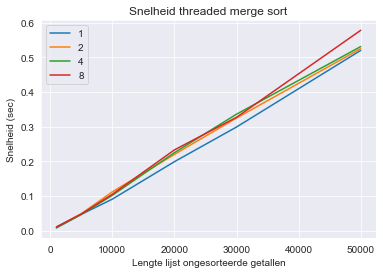

In [8]:
sns.set_style("darkgrid")

# plot for every thread the speed
for thread in timings:
    x = [x[1] for x in timings[thread]]
    y = [x[0] for x in timings[thread]]
    plt.plot(x, y, label=thread)

# add legend
plt.legend(loc="upper left")

# add title and x, y labels
plt.title("Snelheid threaded merge sort")
plt.xlabel("Lengte lijst ongesorteerde getallen")
plt.ylabel("Snelheid (sec)")

plt.show()